In [1]:
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

In [2]:
%cd /mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization/

/mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization


/home/emmt/anaconda3/envs/workshop/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%autoreload 
from code_lib.Forward import *
from code_lib.Training import *

In [4]:
def init_params_equis(layers, key):
  # Equisdi initialization
  vmin = 0
  vmax = 1
  Wv = -1
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    c = jnp.linspace(vmin, vmax, layers[i + 1])#[1:-1]
    W = np.ones((layers[i], layers[i + 1]))
    W[:,1::2]*=Wv

    Ws.append(W)  
    bs.append(-W[0]*c)
  return [Ws, bs]


def init_params_box(layers, key):
  # box_1d initialization
  vmin = 0
  vmax = 1
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    p = jx.random.uniform(subkey, (layers[i], layers[i + 1]), minval =vmin, maxval=vmax)
    key, subkey = jx.random.split(key)
    ndir = jx.random.normal(subkey, (layers[i], layers[i + 1]))
    W = jnp.sign(ndir)*(1/(1-jnp.sign(ndir)*p))#*(ndir>=0)+(1/(1+p))*(ndir<0)
    b = -W[0]*p[0]
    Ws.append(W)  
    bs.append(b)
  return [Ws, bs]

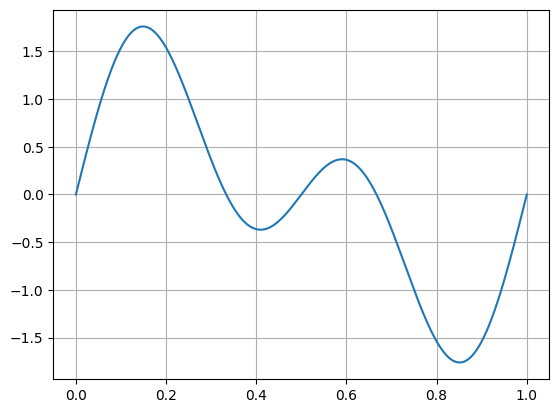

In [5]:

X = jnp.linspace(0,1, 10000)[:, None]
# f = lambda x:jnp.cos(x*2*jnp.pi)-1
# df = lambda x:-2*jnp.pi*jnp.sin(x*2*jnp.pi)
# d2f = lambda x:-4*jnp.pi**2*jnp.cos(x*2*jnp.pi)
f = lambda x:jnp.sin(x*2*jnp.pi*2)+jnp.sin(x*2*jnp.pi)
df = lambda x:4*jnp.pi*jnp.cos(x*2*jnp.pi*2)+2*jnp.pi*jnp.cos(x*2*jnp.pi)
d2f = lambda x:-(4*jnp.pi)**2*jnp.sin(x*2*jnp.pi*2)-(2*jnp.pi)**2*jnp.sin(x*2*jnp.pi)


# f = lambda x:x**2*(1-x)
# df = lambda x:2*x-3*x**2
# d2f = lambda x:2-6*x

# f = lambda x: jnp.arctan(20*(x-0.2))
# df = lambda x: 0.05/(x**2-0.4*x+0.0425)
# d2f = lambda x: (0.02-0.1*x)/(x**2-0.4*x+0.0425)**2
# f = lambda x:jnp.sin(x*2*jnp.pi*3)+jnp.sin(x*2*jnp.pi)
# df = lambda x:6*jnp.pi*jnp.cos(x*2*jnp.pi*3)+2*jnp.pi*jnp.cos(x*2*jnp.pi)
# d2f = lambda x:-(6*jnp.pi)**2*jnp.sin(x*2*jnp.pi*3)-(2*jnp.pi)**2*jnp.sin(x*2*jnp.pi)
Y = f(X)
dY = df(X)
d2Y = d2f(X)

plt.plot(X, Y)
# plt.plot(X, dY)
# plt.plot(X, d2Y)
plt.grid()
plt.show()

In [6]:
layers = [1] + [20]*1 + [1]
bsize = 512*2
nIter = 0
lr = 1e-5
stop_at = 1e-8

trainer = Training2(optimizers.adam, {"lr":lr}, mode="QMC1")
# trainer = Training2(optimizers.sgd, {"lr":lr}, mode="QMC1")

key = jx.random.PRNGKey(0)

X_c = jnp.array([[-1,1]]).T
lmbi = 1#/2
@jx.jit
def loss(params, s, X, Y, X_c):
    # L2
    _, Y_pred = forward_pass_multi(X, params, s)
    MSE= jnp.mean((Y_pred-f(X))**2)*lmbi
    return MSE
# CB = lambda X: (1-X)*X
@jx.jit
def loss(params, s, X, Y, X_c):
    # H1_0
    # _, Y_pred = forward_pass_multi(X_c, params, s)
    _, Y_pred_g = forward_pass_multi_grad(X, params, s)
#     _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = df(X)
    MSE =jnp.mean((Y_pred_g.squeeze()-obj.squeeze())**2)*lmbi
    # MSE+= jnp.mean((Y_pred-f(X_c))**2)
    return MSE
@jx.jit
def loss(params, s, X, Y, X_c):
    #pinn
    # _, Y_pred = forward_pass_multi(X_c, params, s)
    # _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = d2f(X)
    MSE =jnp.mean((Y_pred_g2.squeeze()-obj.squeeze())**2)*lmbi
    # MSE+= jnp.mean((Y_pred-f(X_c))**2)
    return MSE
@jx.jit
def loss(params, s, X, Y, X_c):
    #deep ritz
    _, Y_pred = forward_pass_multi(X, params, s)
    _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    # _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = d2f(X).squeeze()
    du = Y_pred_g.squeeze()
    u = Y_pred.squeeze()
    MSE =jnp.mean((0.5*(du**2)+obj*u))*lmbi
    return MSE

cases = {"he_normal":"he_normal", 
         "glorot_normal":"glorot_normal"}

for ini in cases.keys():
    params = init_params(layers, key, ini)
    opt_state = trainer.opt_init(params)
    params, train_loss, val_loss = trainer.train(loss, 
            X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
    cases[ini] = (params, train_loss)

params = init_params_equis(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["equis"] = (params, train_loss)
params = init_params_box(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["box"] = (params, train_loss)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [7]:
# for j, ini in enumerate(cases.keys()):
#     if ini != "equis": continue
#     params = cases[ini][0]
#     W0, b0 = params
#     W0 = W0[0]
#     b0 = b0[0]
#     L, Y_pred = forward_pass_multi(X, params, params[0][-1])
#     plt.plot(X.squeeze(), L.squeeze())
#     plt.xlim(0,1)
# plt.grid()
# plt.tight_layout()
# plt.show()

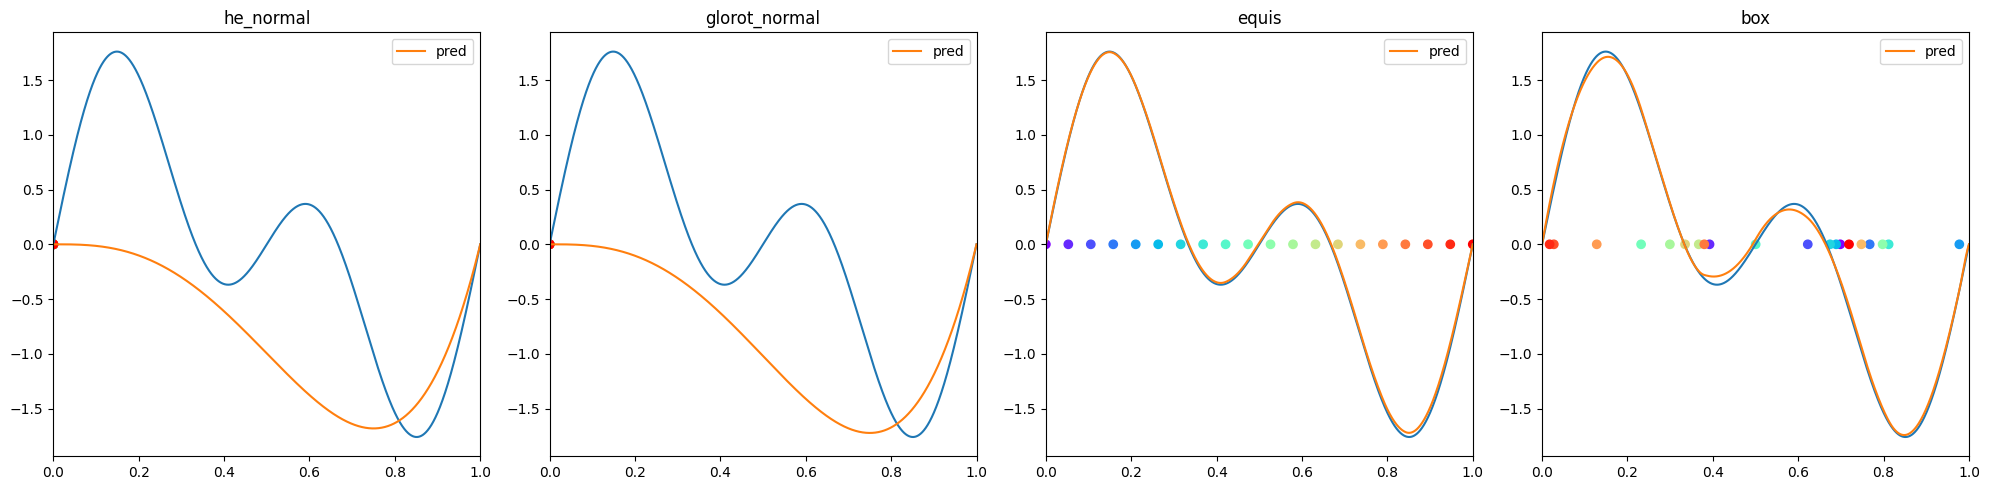

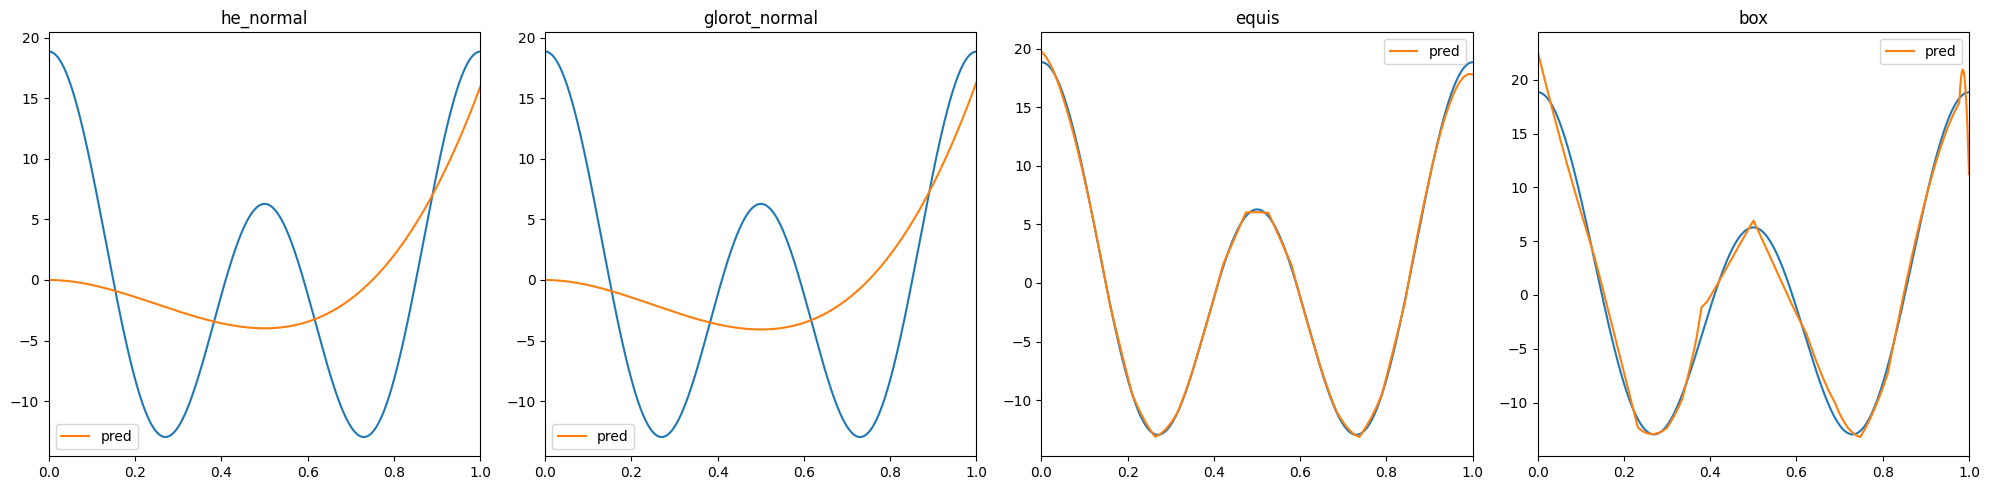

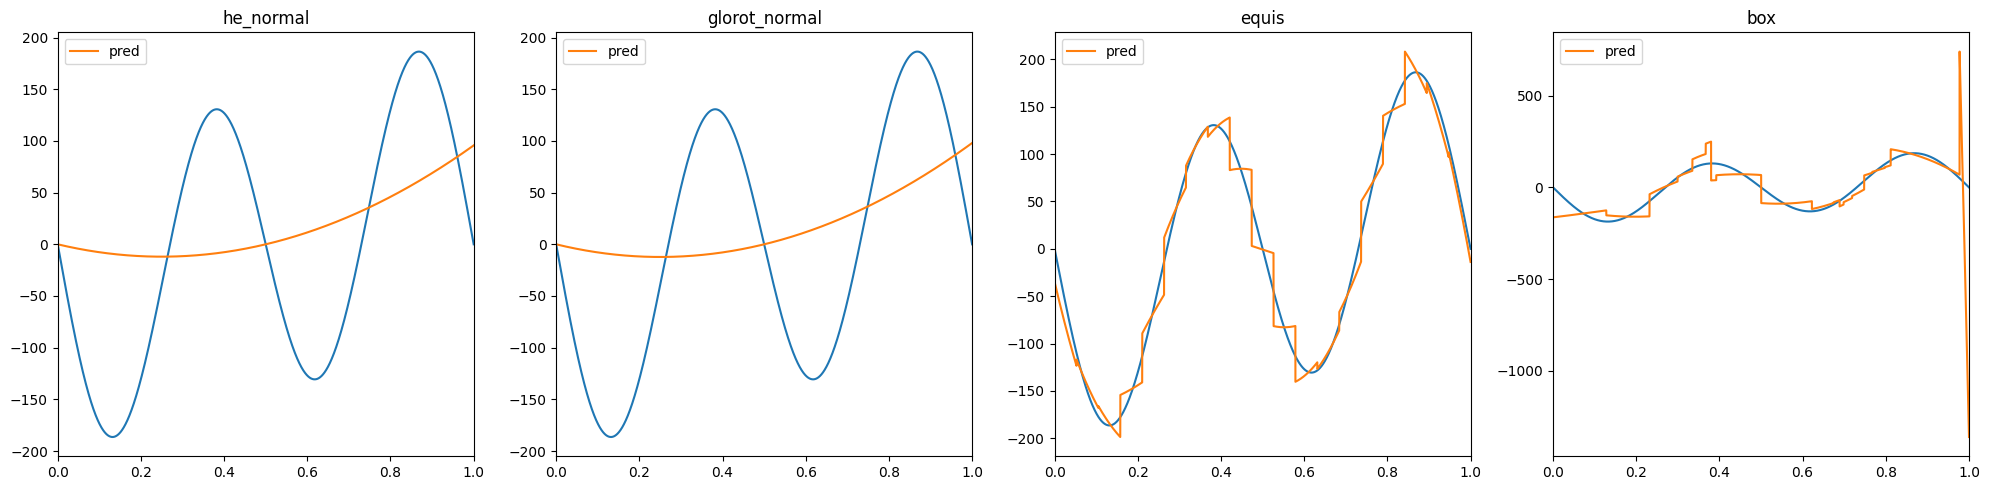

In [8]:
n_cases = len(cases.keys())
plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, Y)
    plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X, Y_pred, label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]

    plt.subplot(1, n_cases, j+1)
    plt.plot(X, dY)
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, d2Y)
    L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()

it 9950, train loss = -4.917509e+01: 100%|██████████████████████████████████████| 10000/10000 [00:07<00:00, 1398.50it/s]
/tmp/ipykernel_123397/630820199.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


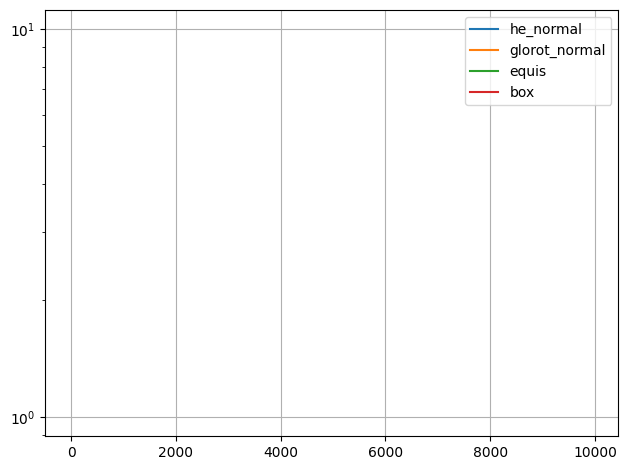

In [9]:
nIter = 10000
cases = {"he_normal":"he_normal", 
         "glorot_normal":"glorot_normal"}

for ini in cases.keys():
    params = init_params(layers, key, ini)
    opt_state = trainer.opt_init(params)
    params, train_loss, val_loss = trainer.train(loss, 
            X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
    cases[ini] = (params, train_loss)

params = init_params_equis(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["equis"] = (params, train_loss)
params = init_params_box(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["box"] = (params, train_loss)

for ini in cases.keys():
    train_loss = cases[ini][1]
    plt.semilogy(np.arange(len(train_loss))*50, train_loss, label=ini)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

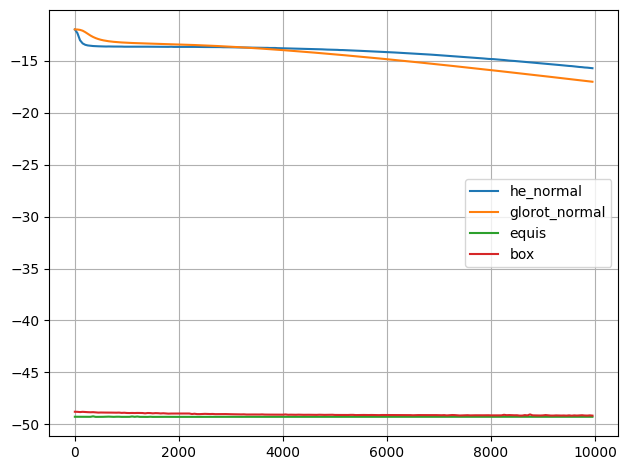

In [10]:
for ini in cases.keys():
    train_loss = cases[ini][1]
    plt.plot(np.arange(len(train_loss))*50, train_loss, label=ini)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

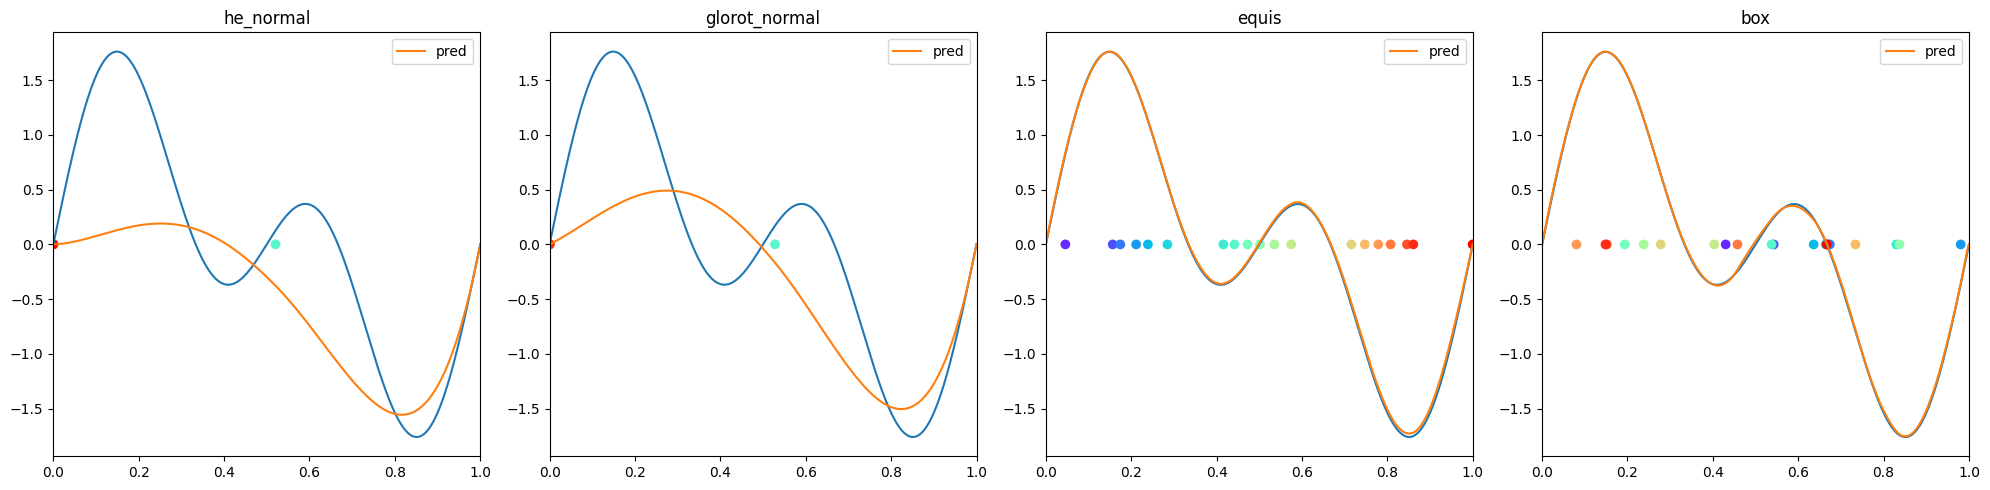

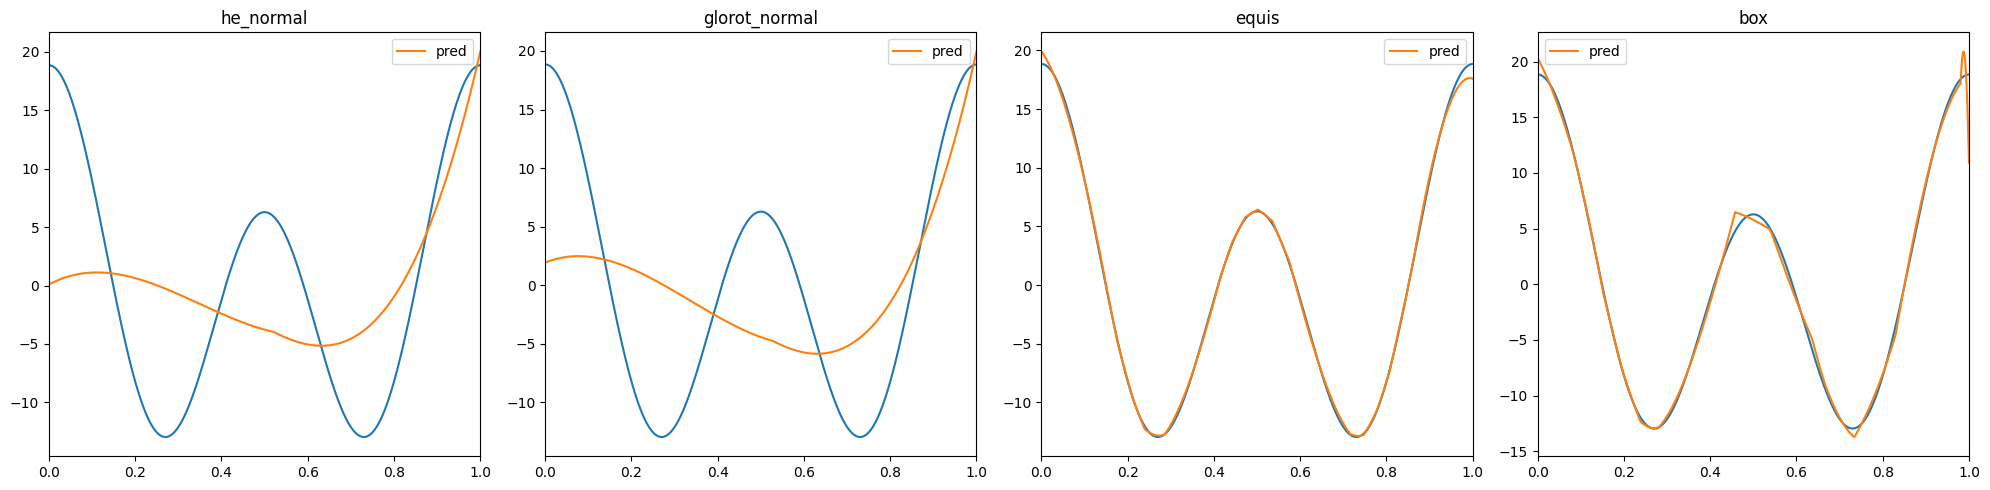

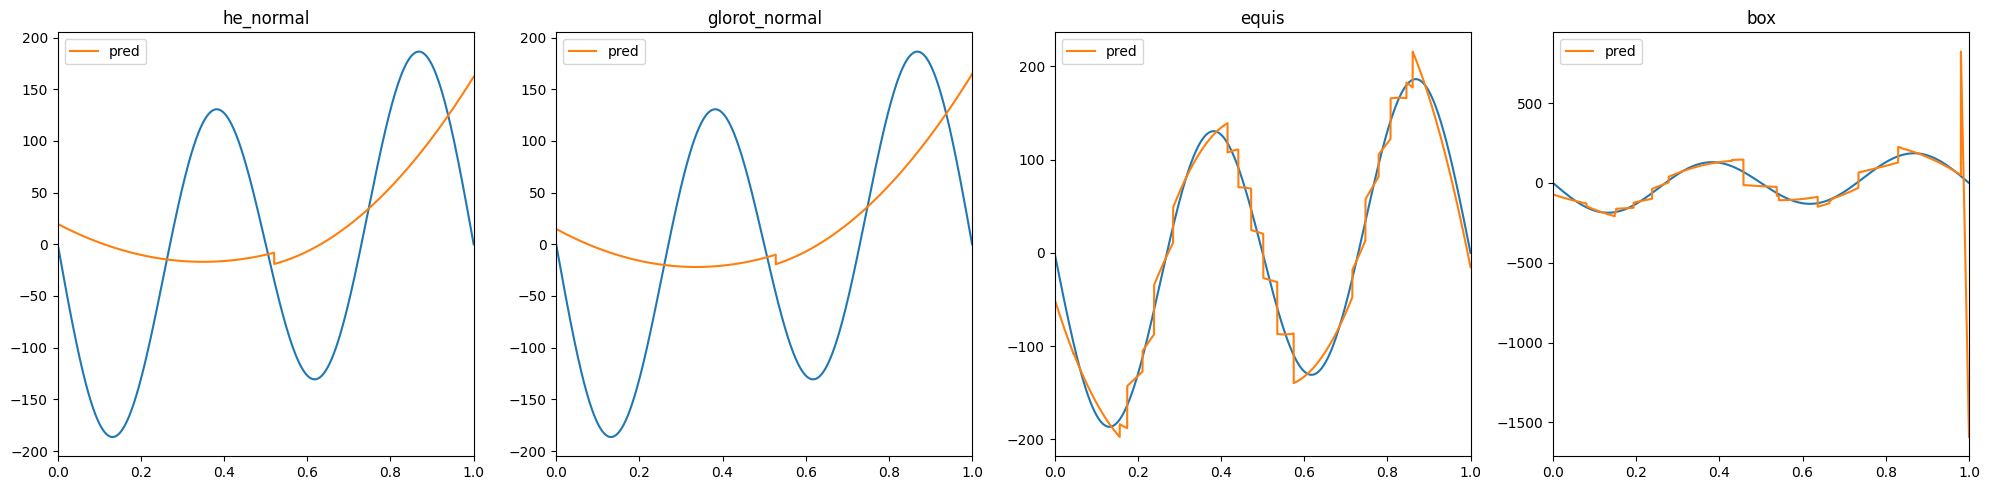

In [11]:
n_cases = len(cases.keys())
plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, Y)
    plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X, Y_pred, label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]

    plt.subplot(1, n_cases, j+1)
    plt.plot(X, dY)
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, d2Y)
    L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(0,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()

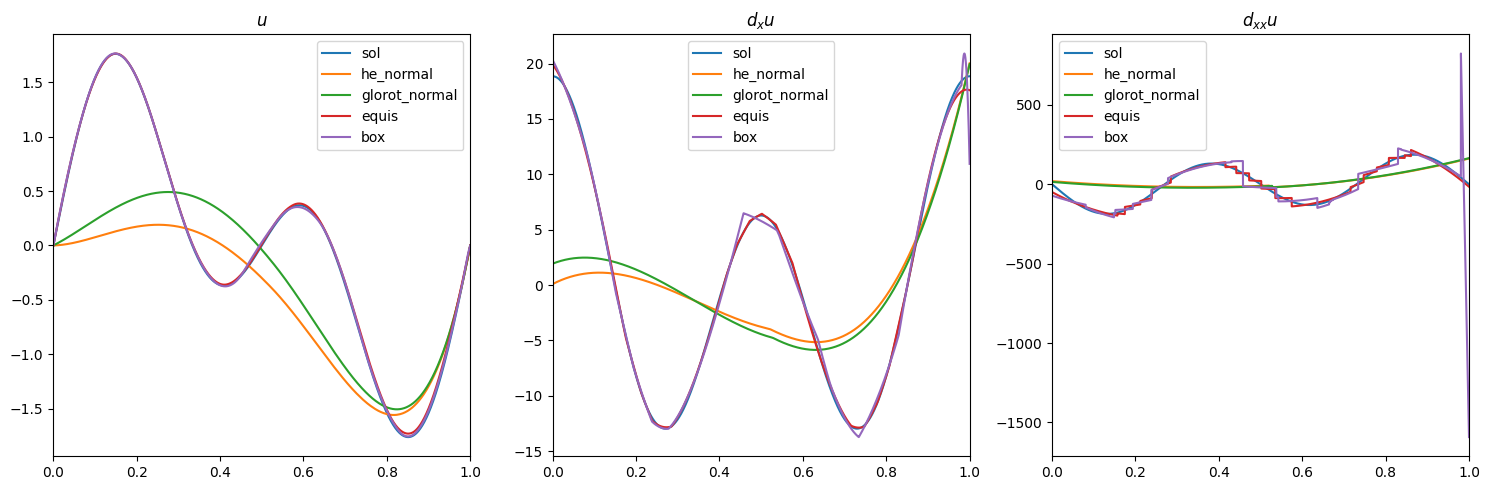

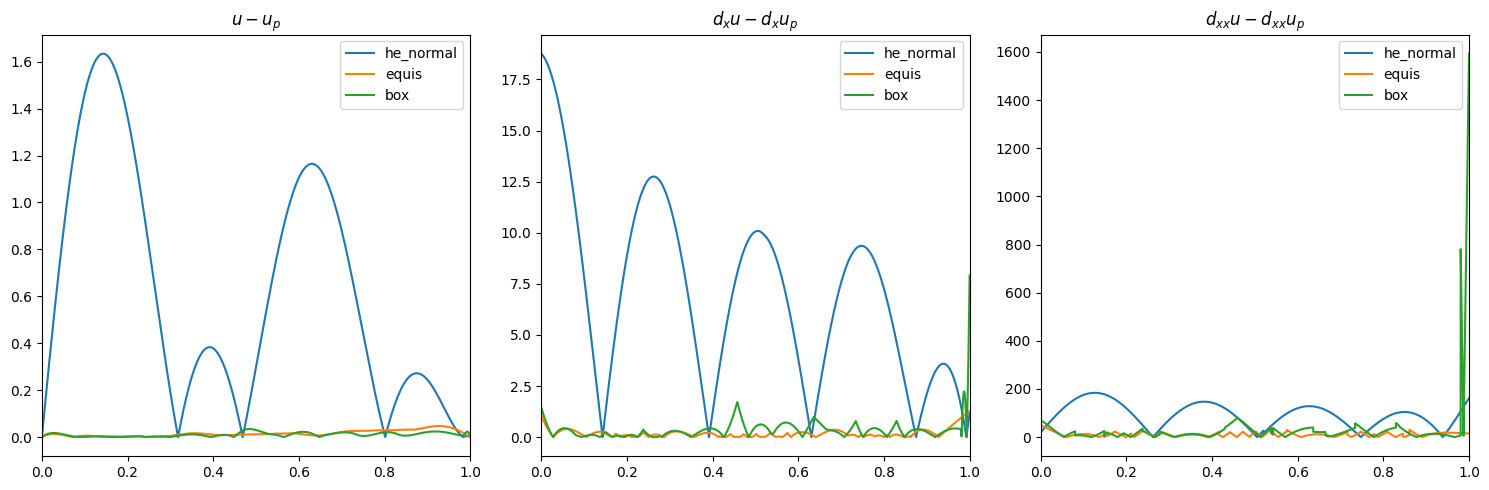

In [12]:
plt.figure(figsize=(5*3, 5))
plt.subplot(1, 3, 1)
plt.title(r"$u$")
plt.plot(X, Y, label="sol")
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X, Y_pred, label=ini)
    plt.xlim(0,1)
plt.legend()
plt.subplot(1, 3, 2)
plt.title(r"$d_{x} u$")
plt.plot(X, dY, label="sol")
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label=ini)
    plt.xlim(0,1)
plt.legend()
plt.subplot(1, 3, 3)
plt.title(r"$d_{xx} u$")
plt.plot(X, d2Y, label="sol")
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label=ini)
    plt.xlim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5*3, 5))
plt.subplot(1, 3, 1)
plt.title(r"$u-u_p$")
# plt.plot(X, Y, label="sol")
for j, ini in enumerate(cases.keys()):
    if ini == "glorot_normal":continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X, jnp.abs(Y_pred.squeeze()-Y.squeeze()), label=ini)
    plt.xlim(0,1)
plt.legend()
plt.subplot(1, 3, 2)
plt.title(r"$d_{x} u - d_{x} u_p$")
# plt.plot(X, dY, label="sol")
for j, ini in enumerate(cases.keys()):
    if ini == "glorot_normal":continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X, jnp.abs(Y_pred.squeeze()-dY.squeeze()), label=ini)
    plt.xlim(0,1)
plt.legend()
plt.subplot(1, 3, 3)
plt.title(r"$d_{xx} u-d_{xx} u_p$")
# plt.plot(X, d2Y, label="sol")
for j, ini in enumerate(cases.keys()):
    if ini == "glorot_normal":continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.plot(X, jnp.abs(Y_pred.squeeze()-d2Y.squeeze()), label=ini)
    plt.xlim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# X = jnp.linspace(0,5, 10000)[:, None]
# plt.plot(X, 2*jx.nn.relu(X)/(X**1+1))
# plt.plot(X, 2*jx.nn.relu(X)**2/(X**2+1))
# plt.plot(X, 2*jx.nn.relu(X)**3/(X**3+1))
# plt.plot(X, 2*jx.nn.relu(X)**4/(X**4+1))
# plt.plot(X, 2*jx.nn.relu(X)**5/(X**5+1))
# plt.plot(X, 2*jx.nn.relu(X)**6/(X**6+1))
# plt.plot(X, 2*jx.nn.relu(X)**10/(X**10+1))
# plt.show()
# plt.plot(X, jx.nn.relu(X))
# plt.plot(X, 0.5*jx.nn.relu(X)**2)
# plt.plot(X, (1/6)*jx.nn.relu(X)**3)
# plt.plot(X, (1/24)*jx.nn.relu(X)**4)
# plt.plot(X, (1/(24*5))*jx.nn.relu(X)**5)
# plt.plot(X, (1/(24*5*6))*jx.nn.relu(X)**6)
# plt.show()

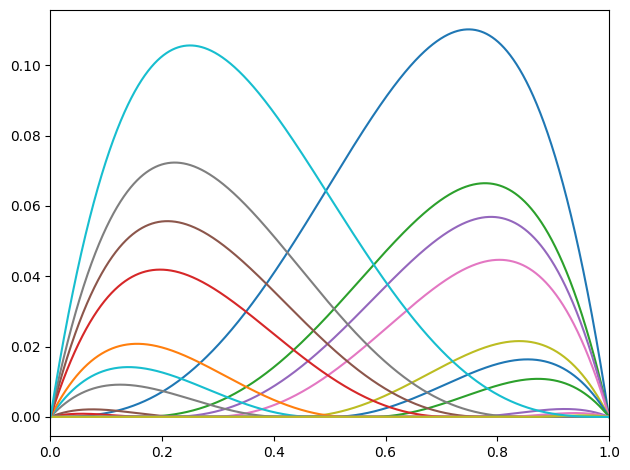

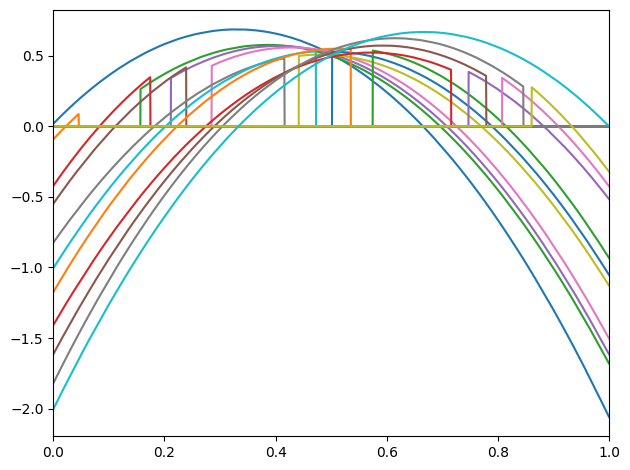

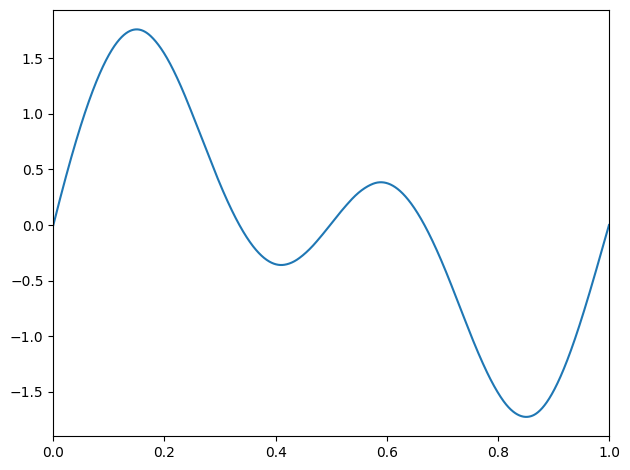

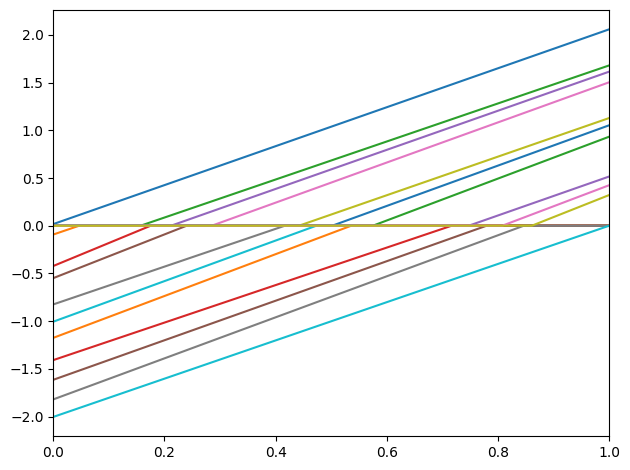

In [14]:
g = lambda x: (x*(1-x))**(1)
for j, ini in enumerate(cases.keys()):
    if ini != "equis": continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X.squeeze(), L.squeeze()*g(X))
    plt.xlim(0,1)
plt.tight_layout()
plt.show()

for j, ini in enumerate(cases.keys()):
    if ini != "equis": continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X.squeeze(), jnp.gradient(L.squeeze()*g(X), axis=0)/X[1])
    plt.xlim(0,1)
plt.tight_layout()
plt.show()

for j, ini in enumerate(cases.keys()):
    if ini != "equis": continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X.squeeze(), Y_pred.squeeze())
    plt.xlim(0,1)
plt.tight_layout()
plt.show()

for j, ini in enumerate(cases.keys()):
    if ini != "equis": continue
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X.squeeze(), L.squeeze())
    plt.xlim(0,1)
plt.tight_layout()
plt.show()